In [1]:
import numpy as np
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import re


In [2]:

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [3]:
SKIP_ROWS = 250 #How often to sample from the data csv files.

In [4]:
FIGURES_FOLDER = "../../figures/"
DATA_FOLDER = "../../data/"

In [5]:
def getDataFiles(substring):
    filenames = os.listdir(DATA_FOLDER)
    return [ filename for filename in filenames if substring in filename ]
def getNumberOfRows(filename):
    with open(filename) as f:
        return sum(1 for line in f)

In [6]:
dataFiles = getDataFiles("bot")
dataFiles = natural_sort(dataFiles)
rawdata = []
for file in dataFiles:
    rows = range(0,getNumberOfRows(DATA_FOLDER + file), SKIP_ROWS)  # fileObject is your csv.reader
    rows_to_skip = list(set(range(0,getNumberOfRows(DATA_FOLDER + file))) - set(rows))
    df = pd.read_csv(DATA_FOLDER + file,skiprows=rows_to_skip)
    rawdata.append(df)
df.head()


,Time,ID,X,Y,Yaw,ResetID,checkCorrectness,NumberOfWalls,WallId(s)
0,0 436000000,0,-0.286543,-0.193029,-0.207896,4,1,0,NaN
1,0 686000000,0,-0.294329,-0.204453,-0.542262,4,1,0,NaN
2,0 936000000,0,-0.302791,-0.239506,-0.968887,4,1,0,NaN
3,1 186000000,0,-0.313607,-0.285419,-1.336910,4,1,0,NaN
4,1 436000000,0,-0.295902,-0.312525,-1.801540,4,1,0,NaN


In [7]:
#find all of the times when there is a 0 at the start of 'time'
timeStartWith0 = []
for d in rawdata:
    l = []
    counter = 1000000
    SKIP_LINES = 20
    for i, v in d['Time'].iteritems():
        #Skip a few lines if we recently found a '0'
        if counter < SKIP_LINES:
            counter += 1
            continue
        if v[0] == str(0):
            l.append(i)
            counter = 0
    timeStartWith0.append(l)
len(timeStartWith0)

8

In [8]:
#timeStartWith0[0]
angles = []
for startRow in timeStartWith0[0]:
    angles.append(rawdata[0].iloc[startRow]['Yaw'])

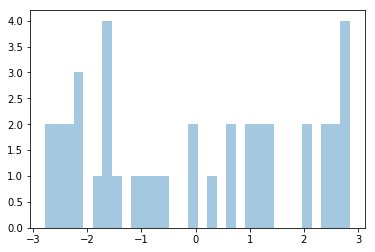

In [9]:
sns.distplot(angles, kde=False,  bins=32)
plt.show()

In [10]:
pathsRows = []
for counter,data in enumerate(timeStartWith0):
    localPathRows = []
    for i in range(len(data)):
        row = data[i]
        if data[len(data)-1] == row:
            #This is final row so go from curr to end
            localPathRows.append(range(row,len(rawdata[counter])))
        else:
            localPathRows.append(range(row,data[i+1]))
    pathsRows.append(localPathRows)
print(len(pathsRows[0]))
len(pathsRows)

40


8

In [11]:
distanceToStart = []
for counter,startdata in enumerate(pathsRows):
    distanceToStartLocal = []
    for ranges in startdata:
        d = rawdata[counter][ranges[0]:ranges[-1]+1]
        startx = float(d.iloc[0]['X'])
        starty = float(d.iloc[0]['Y'])
        for index, row in d.iterrows():
            distance = np.sqrt((float(row['X']) - startx)**2 + (float(row['Y'])-starty)**2)
            distanceToStartLocal.append(distance)
    distanceToStart.append(distanceToStartLocal)
len(distanceToStart)

8

/home/justin/anaconda3/envs/snakes37/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/home/justin/anaconda3/envs/snakes37/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/justin/anaconda3/envs/snakes37/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/home/justin/anaconda3/envs/snakes37/lib/python3.6/site-packages/matplotlib/ticker.py:2198: UserWarning: Data 

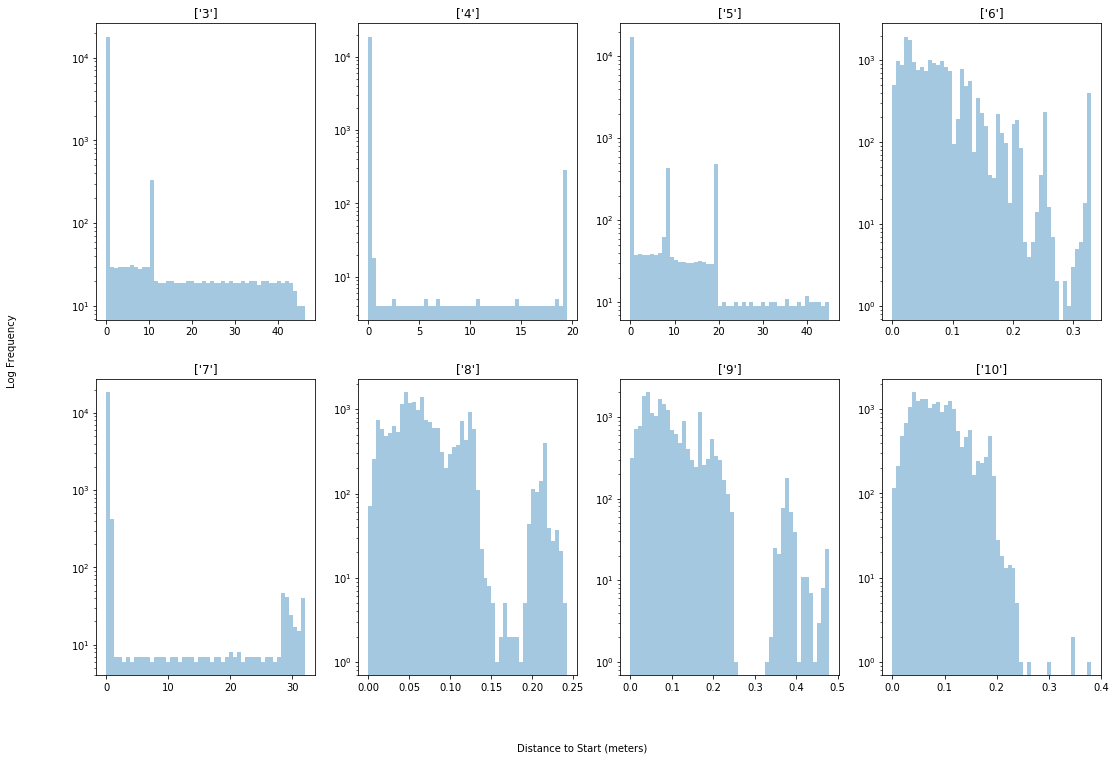

In [12]:

cols = 4
rows = 2
fig, axs = plt.subplots(ncols=cols,nrows=rows)
fig.set_size_inches(18, 12)
#axs[0][1].set(xlim=(0, 10))
#axs[0][2].set(xlim=(0, 10))

for c in range(cols):
    for r in range(rows):
        try:
            i = r*cols + c
            axs[r][c].set_title(re.findall(r'\d+',dataFiles[i]))
            axs[r][c].set_yscale('log')
            sns.distplot(distanceToStart[i], kde=False, ax=axs[r][c])
        except Exception as e:
            pass

fig.text(0.5, 0.04, 'Distance to Start (meters)', ha='center', va='center')
fig.text(0.06, 0.5, 'Log Frequency', ha='center', va='center', rotation='vertical')
fig.savefig(FIGURES_FOLDER + "CLT_distance") 

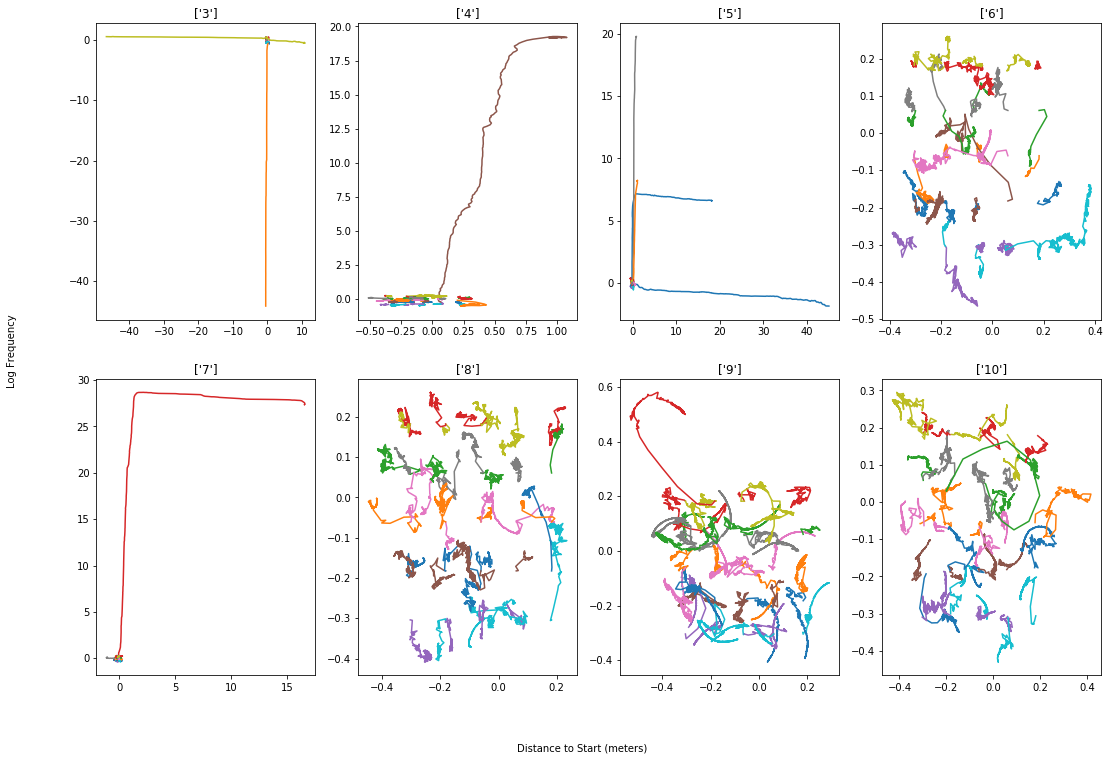

In [13]:
cols = 4
rows = 2
fig, axs = plt.subplots(ncols=cols,nrows=rows)
fig.set_size_inches(18, 12)

for c in range(cols):
    for r in range(rows):
        i = r*cols + c
        axs[r][c].set_title(re.findall(r'\d+',dataFiles[i]))
        for j in range(len(pathsRows[i])):
            rang = pathsRows[i][j]
            dx = [rawdata[i]['X'][k] for k in rang]
            dy = [rawdata[i]['Y'][k] for k in rang]
            axs[r][c].plot(dx, dy)

fig.text(0.5, 0.04, 'Distance to Start (meters)', ha='center', va='center')
fig.text(0.06, 0.5, 'Log Frequency', ha='center', va='center', rotation='vertical')
fig.savefig(FIGURES_FOLDER + "CLT_distance_path") 